In [154]:
# import libraries

# handle dataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, mean_squared_error, make_scorer,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve

from xgboost import XGBClassifier  # Assuming you are using XGBoost for classification; use XGBRegressor for regression


import pprint
from tabulate import tabulate

from sklearn import linear_model

from imblearn.over_sampling import SMOTE
# if there is an error, solve by downgrading to install scikit-learn==1.2.2 
# ''' steps : 
# 1. install pip 
# 2. uninstall sci-kit 
# 3. uninstall imblearn
# 4. install sci-kit 1.2.2 
# 5. install imblearn 
# '''


# Data set from https://www.kaggle.com/datasets/yasserh/loan-default-dataset/data

# Data Pre-Processing

1. We removed variables that are redundant and uncorrelated to the dependent variable such as ID, year. 
2. We removed the NAs. 

In [128]:

# 1. Upload the dataset 
df = pd.read_csv('Loan_Default.csv')
# 2. remove some variables that are redundant such as year, ID
# 3. Removed Interest_rate_spread and rate_of_interest are dropped due to the fact that their values are NA where the loan has defaulted 
# 4. Removed open credit , secured by, total units : only has one value or too few observations 
df = df.drop(['year', 'ID', 'loan_type', 'loan_purpose', 'Interest_rate_spread', 
              'rate_of_interest', 'open_credit','Upfront_charges','construction_type', 
              'Secured_by', 'Security_Type','total_units'], axis=1)

# 5. Removed NAs 
df = df.dropna(subset=["property_value"])
df = df.dropna(subset=["term"])
df = df.dropna(subset=["loan_limit"])
df = df.dropna(subset=["approv_in_adv"])
df = df.dropna(subset=["Neg_ammortization"])
df = df.dropna(subset=["income"])
# Drop rows where sex is not available 
df = df.drop(df[df['Gender'] == 'Not Available'].index)


## 1.1 Imbalanced dataset 
Now we check to see if the data set is imbalanced or not. 

In [145]:

print(df['Status'].value_counts())


0    100978
1     19657
Name: Status, dtype: int64


In [146]:

# We turn these columns into dummy variables since they are categorical and drop the original column in the dataframe 
categorical_columns = ['loan_limit', 'Gender', 'approv_in_adv', 'Credit_Worthiness',
       'business_or_commercial', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'occupancy_type',
        'credit_type', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'Region']

for i in categorical_columns: 
    df = pd.concat([df,pd.get_dummies(df[i],drop_first=True, prefix=i)],axis=1)
    df = df.drop(i,axis=1)


KeyError: 'loan_limit'

# Checking Correlation between values 

In [8]:
correlation_matrix = df.corr()

# Exclude diagonal elements
correlation_matrix_no_diagonal = correlation_matrix.mask(
    pd.DataFrame(np.eye(len(correlation_matrix), dtype=bool), correlation_matrix.index, correlation_matrix.columns))

# Display the correlation matrix without diagonal elements
print("Correlation Matrix (excluding diagonal):")
print(correlation_matrix_no_diagonal)

# Check for high absolute correlation coefficients
threshold = 0.8 
highly_correlated_pairs = []

for i in range(len(correlation_matrix_no_diagonal.columns)):
    for j in range(i):
        correlation = correlation_matrix_no_diagonal.iloc[i, j]
        if abs(correlation) > threshold:
            pair = (correlation_matrix_no_diagonal.columns[i], correlation_matrix_no_diagonal.index[j], correlation)
            highly_correlated_pairs.append(pair)

if highly_correlated_pairs:
    print("\nHighly correlated pairs:")
    for pair in highly_correlated_pairs:
        print(f"{pair[0]} and {pair[1]}: {pair[2]}")
else:
    print("\nNo highly correlated pairs found.")

Correlation Matrix (excluding diagonal):
                                   loan_amount      term  property_value  \
loan_amount                                NaN  0.174069        0.734557   
term                                  0.174069       NaN        0.048861   
property_value                        0.734557  0.048861             NaN   
income                                0.451717 -0.054883        0.415447   
Credit_Score                          0.005377 -0.002933        0.003639   
LTV                                   0.063775  0.209505       -0.442754   
Status                               -0.039615  0.008818       -0.045619   
dtir1                                 0.014500  0.111253       -0.056722   
loan_limit_ncf                        0.258006  0.015988        0.200278   
Gender_Joint                          0.190145  0.021610        0.156026   
Gender_Male                           0.000939  0.010377       -0.028914   
Gender_Sex Not Available             -0.118203 

In [9]:
if highly_correlated_pairs:
    print("\nHighly correlated pairs:")
    for pair in highly_correlated_pairs:
        print(f"{pair[0]} and {pair[1]}: {pair[2]}")
else:
    print("\nNo highly correlated pairs found.")


No highly correlated pairs found.


# Split Train Test dataset

So by looking at the data, we see there are two main types of loans : property loan and non-property loan. 


In [118]:
# define X and y variables as dataframe 
y = df['Status']
X = df.drop('Status',axis=1)
X_train, X_OOS_test, y_train, y_OOS_test = train_test_split(X, y, test_size=0.20, random_state=66)

## Over Sampling 


In [119]:
# Over sample using SMOTE
# -- by inspecting the data, we see that the minority class is extremely class (fraud "Class" == 1)
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

## Setup K-Fold Cross Validation 

In [17]:
# Set up K-Fold Cross Validation 
n_splits = 5
shuffle = True
random_state = 809
cv = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
# plot = plot_cv_indices(cv, X_smote, y_smote, n_splits)



# Model 1 : Linear Regressions (with LASSO and Ridge Regression) 

## Cross Validation for LASSO 

In [50]:
# Model 2 : LASSO 
# Cross Validate the penalty term in lasso
cross_validate_result = {}
cross_validate_recall = {} 
cross_validate_precision = {} 

# Set Hyperparameter (Lambda) values to cross validate here !!!!! 
lambdas = [0.001, 0.01, 0.1]
for lambda_value in lambdas:
    print('Training Lasso Lambda Value : ', lambda_value)
    accuracies = []
    recall_scores = [] 
    precision_scores = [] 
    lasso = linear_model.Lasso(alpha=lambda_value)
    for train_index, test_index in cv.split(X_smote):
        # change to loc to define the rows in the dataframe 
        X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
        lasso.fit(X_cv_train, y_cv_train)
        y_pred = lasso.predict(X_cv_test)
        y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]

        #Cross-Validation Prediction Error
        score = lasso.score(X_cv_test, y_cv_test)
        accuracies.append(score)
        recall_scores.append(recall_score(y_cv_test, y_pred_classification))
        precision_scores.append(precision_score(y_cv_test,y_pred_classification))

    cross_validate_result[lambda_value] = (sum(accuracies)/len(accuracies))
    cross_validate_recall[lambda_value] = (sum(recall_scores)/len(recall_scores))
    cross_validate_precision[lambda_value] = (sum(precision_scores)/len(precision_scores))

    print("Lambda Value Accuracy : " + str(lambda_value) + " " + str((sum(accuracies)/len(accuracies))))
    print("Lambda Value Precision : " + str(lambda_value) + " " + str((sum(recall_scores)/len(recall_scores))))
    print("Lambda Value Recall : " + str(lambda_value) + " " + str((sum(precision_scores)/len(precision_scores))))
    print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Training Lasso Lambda Value :  0.001
Lambda Value Accuracy : 0.001 0.490208479329176
Lambda Value Precision : 0.001 0.7885123026124378
Lambda Value Recall : 0.001 0.8743121394471272

Training Lasso Lambda Value :  0.01
Lambda Value Accuracy : 0.01 0.42957536246474304
Lambda Value Precision : 0.01 0.7914378353713726
Lambda Value Recall : 0.01 0.8454593091922291

Training Lasso Lambda Value :  0.1
Lambda Value Accuracy : 0.1 0.036879230999902354
Lambda Value Precision : 0.1 0.6013263278617567
Lambda Value Recall : 0.1 0.5901291493096974

------------------
Accuracy :  {0.001: 0.490208479329176, 0.01: 0.42957536246474304, 0.1: 0.036879230999902354}
Precision :  {0.001: 0.8743121394471272, 0.01: 0.8454593091922291, 0.1: 0.5901291493096974}
Recall :  {0.001: 0.7885123026124378, 0.01: 0.7914378353713726, 0.1: 0.6013263278617567}


## LASSO vs Ridge vs OLS

In [110]:
# Somehow LASSO is performing worse?
ols = linear_model.LinearRegression()
ols.fit(X_smote, y_smote)    
y_pred = ols.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("OLS Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("OLS Model Precision : ", precision_score(y_OOS_test,y_pred_classification))
print("--")

# LASSO 
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_smote, y_smote)
y_pred = lasso.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("LASSO score : " , )
print("LASSO Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("LASSO Model Precision : ", precision_score(y_OOS_test,y_pred_classification))
print("--")

# RIDGE
ridge = linear_model.Ridge(alpha=3)
ridge.fit(X_smote, y_smote)
y_pred = ridge.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("Ridge Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("Ridge Model Precision : ", precision_score(y_OOS_test,y_pred_classification))

OLS Model Recall :  0.18342597271349168
OLS Model Precision :  0.24568527918781727
--
LASSO score : 
LASSO Model Recall :  0.2561899949469429
LASSO Model Precision :  0.25814663951120165
--
Ridge Model Recall :  0.18342597271349168
Ridge Model Precision :  0.24576844955991875


## Plot the ROC Curve

AUC: 0.6174165341770578


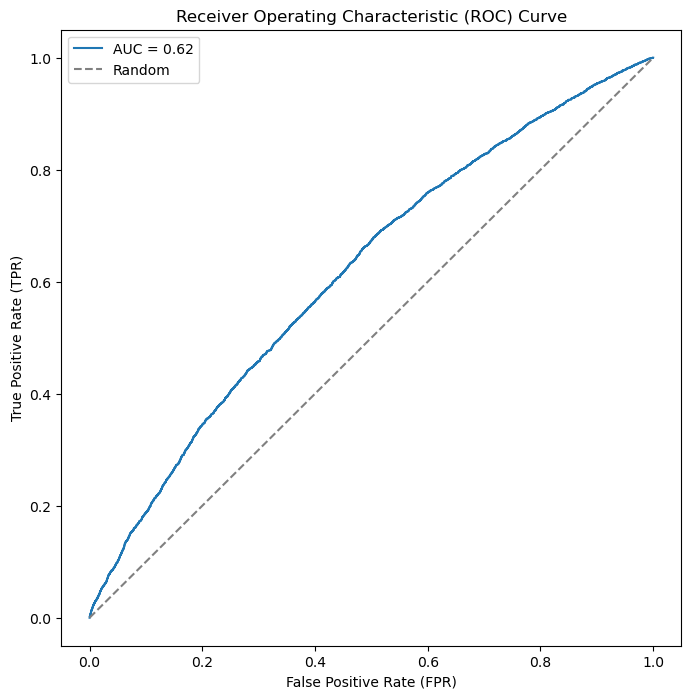

In [116]:
from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities for the positive class
y_prob = lasso.predict(X_OOS_test)

# Calculate AUC
auc = roc_auc_score(y_OOS_test, y_prob)
print(f"AUC: {auc}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_OOS_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

## Confusion Matrix 

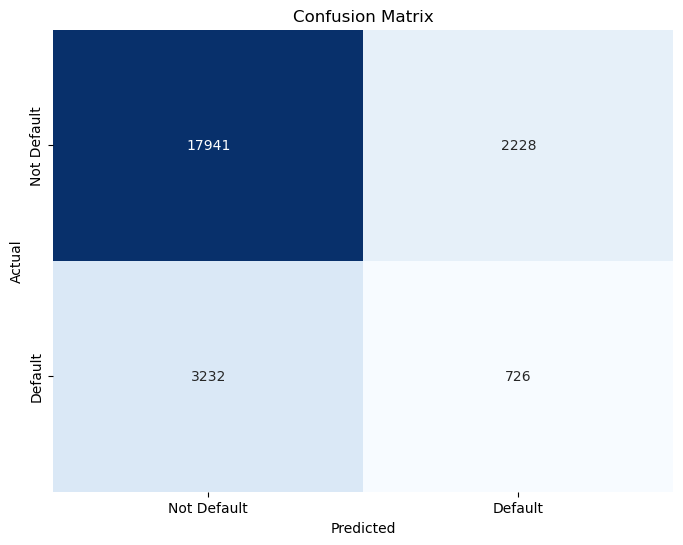

In [114]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_OOS_test, y_pred_classification)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Model 2 : Random Forest

In [66]:

random_forest = RandomForestClassifier(n_estimators = 200, max_depth=5, random_state=0)
random_forest.fit(X_smote, y_smote)

y_pred = random_forest.predict(X_OOS_test)
print("RND Forest Accuracy : " , accuracy_score(y_OOS_test, y_pred))
print("RND Forest Recall : " , recall_score(y_OOS_test, y_pred))
print("RND Forest Precision : ", precision_score(y_OOS_test,y_pred))
print("RND Forest F1 : ", f1_score(y_OOS_test,y_pred))


RND Forest Model Recall :  0.38100050530570995
RND Forest Precision :  0.31416666666666665
RND Forest F1 :  0.34437086092715224


In [ ]:
# Cross Validate Random Forest
param_grid = [{'n_estimators': [200,225,250], 'max_depth' :[10,20,30]}]
random_forest_cv = RandomForestClassifier()
grid_cv = GridSearchCV(estimator=random_forest_cv, cv=cv, param_grid=param_grid, n_jobs = 3)
grid_cv.fit(X_smote, y_smote)

In [2]:
def create_dictionary(param_1,param_2):
    result_dictionary = {} 
    for i in param_1: 
        result_dictionary[i] = {} 
        for j in param_2: 
                result_dictionary[i][j] = {} 
    return result_dictionary


### 2.1 Random Forest Cross Validation

In [19]:
# CV in Trees  
# Set Hyperparameter (Lambda) values to cross validate here !!!!! 
max_depth = [5,10,20]
number_of_trees = [50,100,150] 

cross_validate_result = create_dictionary(number_of_trees,max_depth)
cross_validate_recall = create_dictionary(number_of_trees,max_depth)
cross_validate_precision = create_dictionary(number_of_trees,max_depth) 

for tree in number_of_trees: 
    for depth in max_depth:
        print('Depth of Tree : ', depth, ' Number of Trees ', tree)
        accuracies = []
        recall_scores = [] 
        precision_scores = [] 
        random_forest_cv = RandomForestClassifier(n_estimators = tree, max_depth=depth)
        for train_index, test_index in cv.split(X_smote):
            # change to loc to define the rows in the dataframe 
            X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
            random_forest_cv.fit(X_cv_train, y_cv_train)
            y_pred = random_forest_cv.predict(X_cv_test)

            #Cross-Validation Prediction Error
            score = random_forest_cv.score(X_cv_test, y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(y_cv_test, y_pred))
            precision_scores.append(precision_score(y_cv_test,y_pred))
        
        cross_validate_result[tree][depth] = (sum(accuracies)/len(accuracies))
        cross_validate_recall[tree][depth] = (sum(recall_scores)/len(recall_scores))
        cross_validate_precision[tree][depth] = (sum(precision_scores)/len(precision_scores))

        print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
        print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
        print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
        print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Depth of Tree :  5  Number of Trees  50
Accuracy : 0.8141852705484677
Precision : 0.7881121263025624
Recall : 0.8315359661942878

Depth of Tree :  10  Number of Trees  50
Accuracy : 0.8450853249634077
Precision : 0.8061433201371495
Recall : 0.8742650039894032

Depth of Tree :  20  Number of Trees  50
Accuracy : 0.8788006504754711
Precision : 0.8353310607835125
Recall : 0.9148718603472066

Depth of Tree :  5  Number of Trees  100
Accuracy : 0.8141296128929836
Precision : 0.7926328670931586
Recall : 0.828293501300954

Depth of Tree :  10  Number of Trees  100
Accuracy : 0.8460691386005099
Precision : 0.8060760939800934
Recall : 0.8761503618455437

Depth of Tree :  20  Number of Trees  100
Accuracy : 0.8806630636515823
Precision : 0.8373464913765325
Recall : 0.9167712338420448

Depth of Tree :  5  Number of Trees  150
Accuracy : 0.8151258159757276
Precision : 0.7922083818503254
Recall : 0.8303246535176146

Depth of Tree :  10  Number of Trees  150
Accuracy : 0.8473004314286632
Precision :

           5         10        20
50   0.788112  0.806143  0.835331
100  0.792633  0.806076  0.837346
150  0.792208  0.809709  0.837582


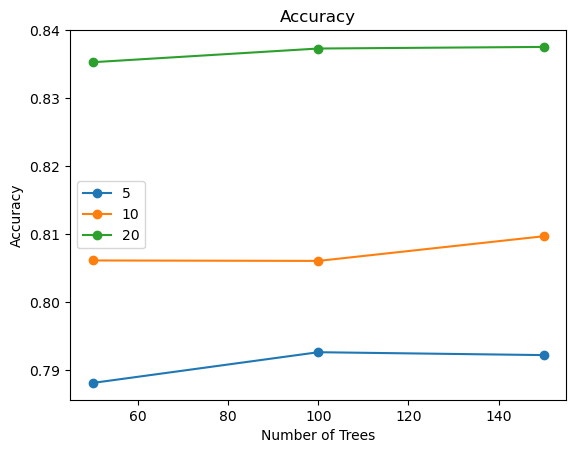

In [32]:
recall_results = pd.DataFrame.from_dict(cross_validate_recall, orient='index')
print(recall_results)
# # Plotting a line plot
recall_results.plot(kind='line', marker='o')

# Display the plot
plt.title('Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.show()

# Model 3 : KNN 

The cross validation results indicated that 3 (neighbours) is the most optimal number. 

In [65]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_smote, y_smote)
# Make predictions on the test data
y_pred = knn.predict(X_OOS_test)
# Evaluate the accuracy of the classifier
print("KNN Accuracy : " , accuracy_score(y_OOS_test, y_pred))
print("KNN Recall : " , recall_score(y_OOS_test, y_pred))
print("KNN Precision : ", precision_score(y_OOS_test,y_pred))
print("KNN F1 : ", f1_score(y_OOS_test,y_pred))


KNN Accuracy :  0.6375430016164463
KNN Recall :  0.4373420919656392
KNN Precision :  0.20984361740817067
KNN F1 :  0.28360776603588106


## Cross Validation for KNN 

In [129]:
# CV in Trees 
# Set Hyperparameter (Lambda) values to cross validate here !!!!!
number_of_neighbours = [1,2,5,10,20] 

cross_validate_result = {}
cross_validate_recall = {} 
cross_validate_precision = {} 

for neighbour in number_of_neighbours: 
    print('Number of Neighbours : ', neighbour)
    accuracies = []
    recall_scores = [] 
    precision_scores = [] 
    knn = KNeighborsClassifier(n_neighbors=neighbour)
    for train_index, test_index in cv.split(X_smote):
        # change to loc to define the rows in the dataframe 
        X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
        knn.fit(X_cv_train, y_cv_train)
        y_pred = knn.predict(X_cv_test)

        #Cross-Validation Prediction Error
        score = knn.score(X_cv_test, y_cv_test)
        accuracies.append(score)
        recall_scores.append(recall_score(y_cv_test, y_pred))
        precision_scores.append(precision_score(y_cv_test,y_pred))
    
    cross_validate_result[neighbour] = (sum(accuracies)/len(accuracies))
    cross_validate_recall[neighbour] = (sum(recall_scores)/len(recall_scores))
    cross_validate_precision[neighbour] = (sum(precision_scores)/len(precision_scores))

    print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
    print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
    print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
    print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Number of Neighbours :  1
Accuracy : 0.7491306930716343
Precision : 0.7913814929899982
Recall : 0.7297182708745649

Number of Neighbours :  2
Accuracy : 0.7208912490896946
Precision : 0.6143489063987174
Recall : 0.7807035859110011

Number of Neighbours :  5
Accuracy : 0.7150626918813072
Precision : 0.7600030502917845
Recall : 0.6973337101550398

Number of Neighbours :  10
Accuracy : 0.6934252546752455
Precision : 0.6760488446216651
Recall : 0.7003987598554531

Number of Neighbours :  20
Accuracy : 0.6729262988530459
Precision : 0.6758568740529208
Recall : 0.6719393446404093

------------------
Accuracy :  {1: 0.7491306930716343, 2: 0.7208912490896946, 5: 0.7150626918813072, 10: 0.6934252546752455, 20: 0.6729262988530459}
Precision :  {1: 0.7297182708745649, 2: 0.7807035859110011, 5: 0.6973337101550398, 10: 0.7003987598554531, 20: 0.6719393446404093}
Recall :  {1: 0.7913814929899982, 2: 0.6143489063987174, 5: 0.7600030502917845, 10: 0.6760488446216651, 20: 0.6758568740529208}


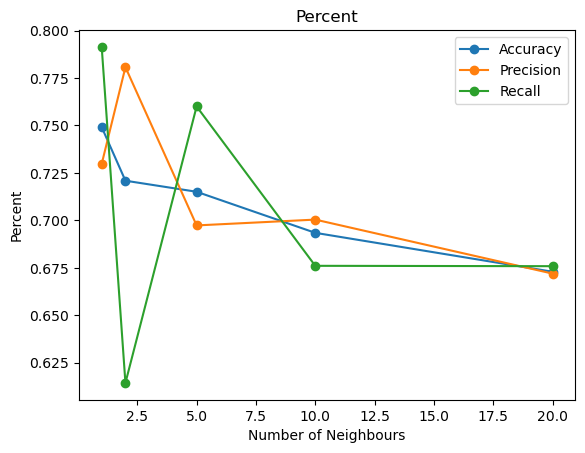

In [130]:
# # Plotting a line plot
# print(cross_validate_precision)
array = {'Accuracy' :  cross_validate_result, 
        'Precision' :  cross_validate_precision ,
        'Recall' :  cross_validate_recall}
pd.DataFrame(array).plot(kind='line', marker='o')
# Display the plot
plt.title('Percent')
plt.xlabel('Number of Neighbours')
plt.ylabel('Percent')
plt.show()

# Model 5 : LASSO and Random Forest

In [142]:
# LASSO 
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_smote, y_smote)
y_pred = lasso.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
# See LASSO coefficient that is 0 
lasso_coefficients = pd.Series(lasso.coef_)
non_zero_lasso_coefficients = lasso_coefficients[lasso_coefficients != 0]



In [169]:
column_names = df.drop('Status', axis=1).columns
lasso_col_names = []
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        lasso_col_names.append(column_names[i])
        print(column_names[i], ' : ' , lasso.coef_[i])

print(lasso_col_names)

[ 7.93758019e-08  0.00000000e+00 -5.65264857e-08 -7.83397201e-06
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00]
loan_amount  :  7.9375801942218e-08
property_value  :  -5.6526485724506996e-08
income  :  -7.833972009250601e-06
['loan_amount', 'property_value', 'income']


In [144]:
X_lasso_rf_train = X_smote[lasso_col_names]
X_lasso_rf_test = X_OOS_test[lasso_col_names]
random_forest = RandomForestClassifier(n_estimators = 100, max_depth=5, random_state=0)
random_forest.fit(X_lasso_rf_train, y_smote)
y_pred = random_forest.predict(X_lasso_rf_test)
print("RND Forest Model Recall : " , recall_score(y_OOS_test, y_pred))
print("RND Forest Precision : ", precision_score(y_OOS_test,y_pred))
print("RND Forest and LASSO MSE : ", mean_squared_error(y_OOS_test,y_pred))
print("RND Forest and LASSO f1 : ", f1_score(y_OOS_test,y_pred))


RND Forest Model Recall :  0.6139464375947449
RND Forest Precision :  0.23610571317528178
RND Forest and LASSO MSE :  0.38919053342728066
RND Forest and LASSO f1 :  0.3410526315789474


## Cross Validation for LASSO and randomforest

In [64]:
# CV in Trees  
# Set Hyperparameter (Lambda) values to cross validate here !!!!! 
max_depth = [2, 3, 4]
number_of_trees = [5,10,15] 

cross_validate_result = create_dictionary(number_of_trees,max_depth)
cross_validate_recall = create_dictionary(number_of_trees,max_depth)
cross_validate_precision = create_dictionary(number_of_trees,max_depth) 

for tree in number_of_trees: 
    for depth in max_depth:
        print('Depth of Tree : ', depth, ' Number of Trees ', tree)
        accuracies = []
        recall_scores = [] 
        precision_scores = [] 
        random_forest_cv = RandomForestClassifier(n_estimators = tree, max_depth=depth)
        for train_index, test_index in cv.split(X_smote):
            # change to loc to define the rows in the dataframe 
            X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_lasso_rf_train.iloc[train_index], X_lasso_rf_train.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
            random_forest_cv.fit(X_cv_train, y_cv_train)
            y_pred = random_forest_cv.predict(X_cv_test)

            #Cross-Validation Prediction Error
            score = random_forest_cv.score(X_cv_test, y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(y_cv_test, y_pred))
            precision_scores.append(precision_score(y_cv_test,y_pred))
        
        cross_validate_result[tree][depth] = (sum(accuracies)/len(accuracies))
        cross_validate_recall[tree][depth] = (sum(recall_scores)/len(recall_scores))
        cross_validate_precision[tree][depth] = (sum(precision_scores)/len(precision_scores))

        print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
        print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
        print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
        print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Depth of Tree :  2  Number of Trees  5
Accuracy : 0.5898970807910194
Precision : 0.5600514433592819
Recall : 0.5960859138716283

Depth of Tree :  3  Number of Trees  5
Accuracy : 0.6028969716073906
Precision : 0.6320289001728526
Recall : 0.5975296460241809

Depth of Tree :  4  Number of Trees  5
Accuracy : 0.6066650987112998
Precision : 0.598612368126647
Recall : 0.6089193795794439

Depth of Tree :  2  Number of Trees  10
Accuracy : 0.5953731298159273
Precision : 0.6041965507061027
Recall : 0.593735225239221

Depth of Tree :  3  Number of Trees  10
Accuracy : 0.6015109811705502
Precision : 0.6334501039068922
Recall : 0.5955423320631559

Depth of Tree :  4  Number of Trees  10
Accuracy : 0.6084904183967266
Precision : 0.6153576420941061
Recall : 0.6072664926564537

Depth of Tree :  2  Number of Trees  15
Accuracy : 0.5956700913690367
Precision : 0.5658451977712038
Recall : 0.6022292393645742

Depth of Tree :  3  Number of Trees  15
Accuracy : 0.603589981948197
Precision : 0.629917915617

# Model 6 : Gradient Boosting 

From the results above, we see that the OOS results could do a lot better. In this next model, we tried the 

In [67]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=5, random_state=0).fit(X_smote, y_smote)
y_pred = clf.predict(X_OOS_test)
print("Gradient Boosting Accuracy : " , accuracy_score(y_OOS_test, y_pred))
print("Gradient Boosting Recall : " , recall_score(y_OOS_test, y_pred))
print("Gradient Boosting Precision : ", precision_score(y_OOS_test,y_pred))
print("Gradient Boosting f1 : ", f1_score(y_OOS_test,y_pred))


Gradient Boosting Accuracy :  0.8529862809300783
Gradient Boosting Recall :  0.3309752400202122
Gradient Boosting Precision :  0.5930285196921684
Gradient Boosting f1 :  0.4248419004378141


## Cross Validation for Gradient Boosting

In [47]:
# CV in Trees 
# Set Hyperparameter (Lambda) values to cross validate here !!!!!
learning_rates = [0.01,0.1,0.25,0.5,1]
max_depth = [3,5,10]

cross_validate_result = create_dictionary(learning_rates,max_depth)
cross_validate_recall = create_dictionary(learning_rates,max_depth)
cross_validate_precision = create_dictionary(learning_rates,max_depth) 

for rate in learning_rates: 
    for depth in max_depth:
        print('Depth of Tree : ', depth, ' Learning rate ', rate)
        accuracies = []
        recall_scores = [] 
        precision_scores = [] 
        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=rate, max_depth=depth, random_state=0)
        for train_index, test_index in cv.split(X_smote):
            # change to loc to define the rows in the dataframe 
            X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
            clf.fit(X_cv_train, y_cv_train)
            y_pred = clf.predict(X_cv_test)

            #Cross-Validation Prediction Error
            score = clf.score(X_cv_test, y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(y_cv_test, y_pred))
            precision_scores.append(precision_score(y_cv_test,y_pred))
        
        cross_validate_result[rate][depth] = (sum(accuracies)/len(accuracies))
        cross_validate_recall[rate][depth] = (sum(recall_scores)/len(recall_scores))
        cross_validate_precision[rate][depth] = (sum(precision_scores)/len(precision_scores))

        print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
        print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
        print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
        print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Depth of Tree :  3  Number of Trees  150
Accuracy : 0.7767389544932674
Precision : 0.7838862288907824
Recall : 0.7728541682170349

Depth of Tree :  5  Number of Trees  150
Accuracy : 0.812397141022144
Precision : 0.7909555946935181
Recall : 0.8264105389470753

Depth of Tree :  10  Number of Trees  150
Accuracy : 0.8462980591780168
Precision : 0.7990479067475149
Recall : 0.8824633127964786

Depth of Tree :  3  Number of Trees  150
Accuracy : 0.8604672827690175
Precision : 0.826632744327712
Recall : 0.8866323853623914

Depth of Tree :  5  Number of Trees  150
Accuracy : 0.8805887991440562
Precision : 0.844553733411118
Recall : 0.9101551190817162

Depth of Tree :  10  Number of Trees  150
Accuracy : 0.9069967533155536
Precision : 0.8707383710746539
Recall : 0.9388250260087829

Depth of Tree :  3  Number of Trees  150
Accuracy : 0.8768887151213981
Precision : 0.842939654154557
Recall : 0.9043412802512532

Depth of Tree :  5  Number of Trees  150
Accuracy : 0.9058149422751909
Precision : 0.

In [36]:
def plot_result(dataframe, X_axis, Y_axis, title):
    results = pd.DataFrame.from_dict(dataframe, orient='index')
    # # Plotting a line plot
    results.plot(kind='line', marker='o')

    # Display the plot
    plt.title(title)
    plt.xlabel(X_axis)
    plt.ylabel(Y_axis)
    plt.show()

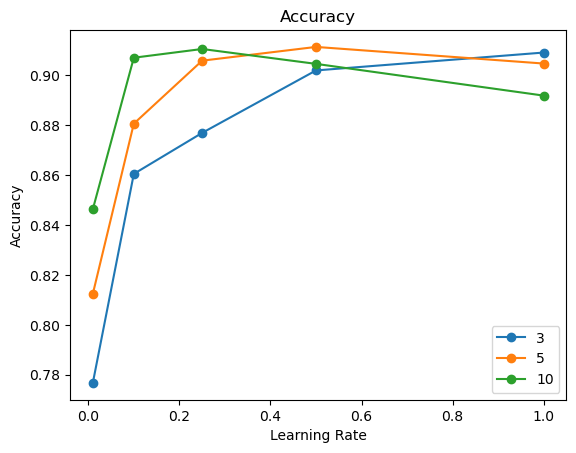

In [62]:
plot_result(cross_validate_result, 'Learning Rate', 'Accuracy', 'Accuracy')

In [58]:
pprint.pprint(cross_validate_result)

{0.01: {3: 0.7767389544932674, 5: 0.812397141022144, 10: 0.8462980591780168},
 0.1: {3: 0.8604672827690175, 5: 0.8805887991440562, 10: 0.9069967533155536},
 0.25: {3: 0.8768887151213981, 5: 0.9058149422751909, 10: 0.9104926439678833},
 0.5: {3: 0.9019045014569806, 5: 0.9113217691845839, 10: 0.9045341418171947},
 1: {3: 0.9090695424294782, 5: 0.9046640863766507, 10: 0.891818992325879}}


# Adaboost

In [69]:
from sklearn.ensemble import AdaBoostClassifier

Adaboost Accuracy :  0.8529862809300783
Adaboost Recall :  0.3309752400202122
Adaboost Precision :  0.5930285196921684
Adaboost f1 :  0.4248419004378141
AUC: 0.6432009424356105


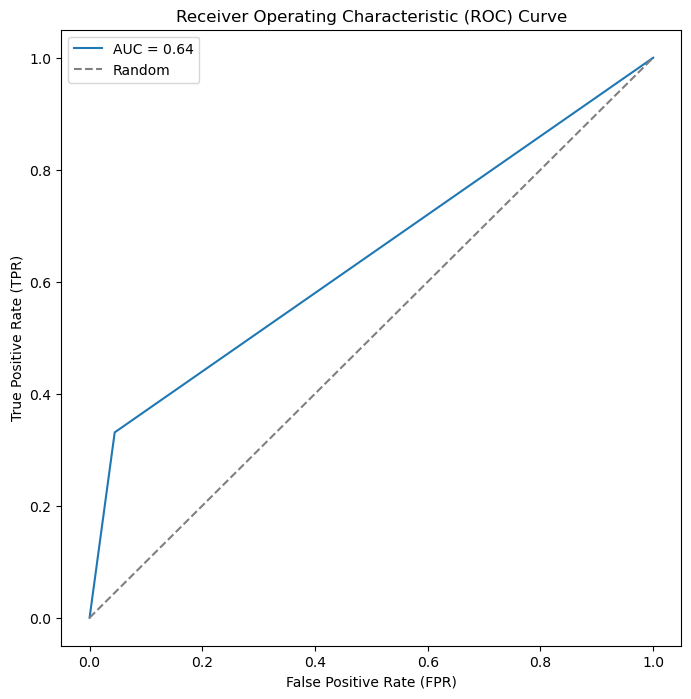

In [165]:
# Create a weak learner (e.g., Decision Tree)
weak_learner = DecisionTreeClassifier(max_depth=1)

# Create an AdaBoost classifier using the weak learner
adaboost_classifier = AdaBoostClassifier(estimator=weak_learner, n_estimators=1000, random_state=0)

# Train the AdaBoost classifier
adaboost_classifier.fit(X_smote, y_smote)

y_pred = clf.predict(X_OOS_test)
print("Adaboost Accuracy : " , accuracy_score(y_OOS_test, y_pred))
print("Adaboost Recall : " , recall_score(y_OOS_test, y_pred))
print("Adaboost Precision : ", precision_score(y_OOS_test,y_pred))
print("Adaboost f1 : ", f1_score(y_OOS_test,y_pred))

# Calculate AUC
auc = roc_auc_score(y_OOS_test, y_pred)
print(f"AUC: {auc}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_OOS_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

In [167]:
print("Adaboost f1 : ", mean_squared_error(y_OOS_test,y_pred))

Adaboost f1 :  0.14701371906992167


## Cross Validation for Adaboost

In [90]:
# CV in Trees 
# Set Hyperparameter (Lambda) values to cross validate here !!!!!
learning_rates = [0]
number_of_trees = [50,100,250,500]

cross_validate_result = create_dictionary(learning_rates,number_of_trees)
cross_validate_recall = create_dictionary(learning_rates,number_of_trees)
cross_validate_precision = create_dictionary(learning_rates,number_of_trees) 

for rate in learning_rates: 
    for tree in number_of_trees:
        print('Depth of Tree : ', tree, ' Learning rate ', rate)
        accuracies = []
        recall_scores = [] 
        precision_scores = [] 
        adaboost_classifier = AdaBoostClassifier(estimator=weak_learner, n_estimators=tree, random_state=0)
        for train_index, test_index in cv.split(X_smote):
            # change to loc to define the rows in the dataframe 
            X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
            adaboost_classifier.fit(X_cv_train, y_cv_train)
            y_pred = adaboost_classifier.predict(X_cv_test)

            #Cross-Validation Prediction Error
            score = adaboost_classifier.score(X_cv_test, y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(y_cv_test, y_pred))
            precision_scores.append(precision_score(y_cv_test,y_pred))
        
        cross_validate_result[rate][tree] = (sum(accuracies)/len(accuracies))
        cross_validate_recall[rate][tree] = (sum(recall_scores)/len(recall_scores))
        cross_validate_precision[rate][tree] = (sum(precision_scores)/len(precision_scores))

        print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
        print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
        print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
        print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Depth of Tree :  50  Learning rate  0
Accuracy : 0.8511118759380258
Precision : 0.8349574334837758
Recall : 0.8628386999931793

Depth of Tree :  100  Learning rate  0
Accuracy : 0.8557772004361235
Precision : 0.837668103729779
Recall : 0.8691481835156616

Depth of Tree :  250  Learning rate  0
Accuracy : 0.8618903747362919
Precision : 0.8423074236485156
Recall : 0.8766470530523236

Depth of Tree :  500  Learning rate  0
Accuracy : 0.868900729585459
Precision : 0.848261189281027
Recall : 0.8847872546225078

------------------
Accuracy :  {0: {50: 0.8511118759380258, 100: 0.8557772004361235, 250: 0.8618903747362919, 500: 0.868900729585459}}
Precision :  {0: {50: 0.8628386999931793, 100: 0.8691481835156616, 250: 0.8766470530523236, 500: 0.8847872546225078}}
Recall :  {0: {50: 0.8349574334837758, 100: 0.837668103729779, 250: 0.8423074236485156, 500: 0.848261189281027}}


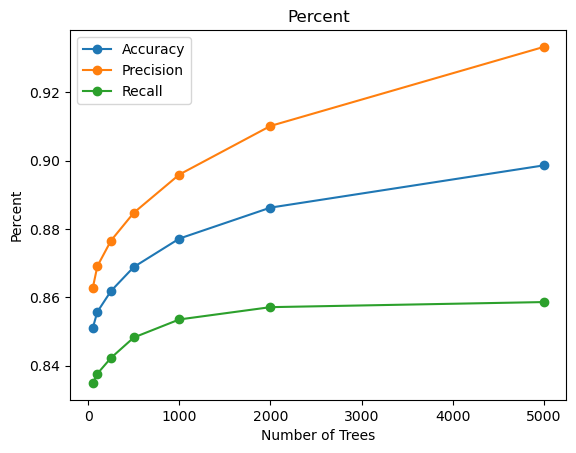

In [93]:
# # Plotting a line plot
# print(cross_validate_precision)
array = {'Accuracy' :  {50: 0.8511118759380258, 100: 0.8557772004361235, 250: 0.8618903747362919, 500: 0.868900729585459, 
                        1000: 0.8772228335260761, 2000: 0.8862874227040762, 5000: 0.89864990838533}, 
        'Precision' :  {50: 0.8628386999931793, 100: 0.8691481835156616, 250: 0.8766470530523236, 500: 0.8847872546225078,
                        1000: 0.8959802768162264, 2000: 0.9101978987498927, 5000: 0.9333374504582311} ,
        'Recall' :  {50: 0.8349574334837758, 100: 0.837668103729779, 250: 0.8423074236485156, 500: 0.848261189281027,
                     1000: 0.8535458326974188, 2000: 0.8571430416392749, 5000: 0.8586321989034067}}
pd.DataFrame(array).plot(kind='line', marker='o')
# Display the plot
plt.title('Percent')
plt.xlabel('Number of Trees')
plt.ylabel('Percent')
plt.show()

# XGBoost

In [105]:
for col in X_smote.columns:
    if '<' in col or ',' in col:
        print(f"Column name with '<' or ',': {col}")

In [159]:
import xgboost as xgb
X_smote_xg = X_smote.rename(columns={'age_<25': 'less_than_25'})
X_OOS_test_xg = X_OOS_test.rename(columns={'age_<25': 'less_than_25'})

dtrain = xgb.DMatrix(X_smote_xg, label=y_smote)
dtest = xgb.DMatrix(X_OOS_test_xg, label=y_OOS_test)

# Set hyperparameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8
}

XGBoost = XGBClassifier(objective='binary:logistic', random_state=42,n_estimators=200,max_depth=7,learning_rate=0.1)
XGBoost.fit(X_smote_xg,y_smote)

# Make predictions on the test set
y_pred_prob = XGBoost.predict(X_OOS_test_xg)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred_prob]

In [161]:
print("XGBoost Accuracy : " , accuracy_score(y_OOS_test, y_pred))
print("XGBoost Recall : " , recall_score(y_OOS_test, y_pred))
print("XGBoost Precision : ", precision_score(y_OOS_test,y_pred))
print("XGBoost MSE : ", mean_squared_error(y_OOS_test,y_pred))
print("XGBoost f1 : ", f1_score(y_OOS_test,y_pred))

XGBoost Accuracy :  0.8492560202263025
XGBoost Recall :  0.3552299140980293
XGBoost Precision :  0.5644319550381373
XGBoost MSE :  0.15074397977369752
XGBoost f1 :  0.43603659482090246


AUC: 0.6507172427349683


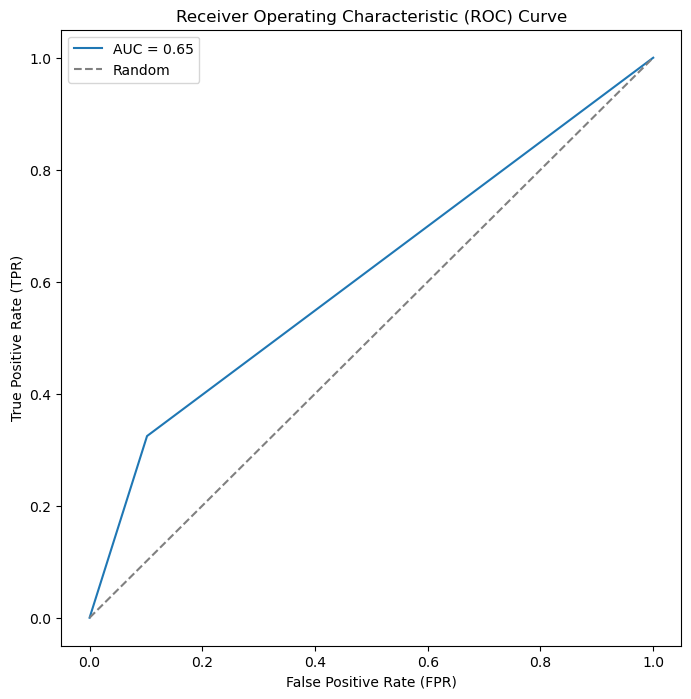

In [163]:

# Calculate AUC
auc = roc_auc_score(y_OOS_test, y_pred_prob)
print(f"AUC: {auc}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_OOS_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

### Cross Validation for XGBoost

In [168]:
from xgboost import XGBClassifier  # Assuming you are using XGBoost for classification; use XGBRegressor for regression

XGBoost = XGBClassifier(objective='binary:logistic', random_state=42)

# Define the hyperparameters and their respective values to be explored
param_grid = {
    'max_depth': [1, 3, 5, 10, 20, 30],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'n_estimators': [50, 100, 200, 300, 500 ]
    # Add more hyperparameters and values as needed
}

# Create the GridSearchCV object
scoring = {'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score)}
grid_search = GridSearchCV(XGBoost, param_grid, cv=cv, scoring=scoring,refit='precision', n_jobs=-1)

# Fit the model with different hyperparameter combinations
grid_search.fit(X_smote_xg, y_smote)

# Print the best hyperparameters and corresponding accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f'Best Hyperparameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_accuracy:.4f}')

/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
Best Cross-Validation Accuracy: 0.9467
